# In this notebook I will explain the full process to get the clothes and color of a given dataset of images

Table of contents :
- I. Extract person on image using YOLO
    - 1. Detect objects
    - 2. Detect person

- II. Extract clothes on a person image using Roboflow
- III. Extract color on clothes using KMeans and KNN
- IV. Final extraction

This method highly depends on the precision on the model we use

In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import matplotlib.pyplot as plt
import scripts.extract_clothes_roboflow as ecr
import scripts.extract_main_color as emc
import scripts.extract_person_yolo as epy
import scripts.main_utilities as mu
import scripts.search_engine as se
import pandas as pd
from roboflow import Roboflow
import os
import torch
from ultralytics import YOLO

# I. Extract person using YOLO

In [3]:
device = torch.device('cpu')
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


MODEL_DETECT_OBJ    = YOLO('yolov8n.pt')
MODEL_DETECT_OBJ.to(device) 

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

# Example of an image process by our scripts

### Load the image

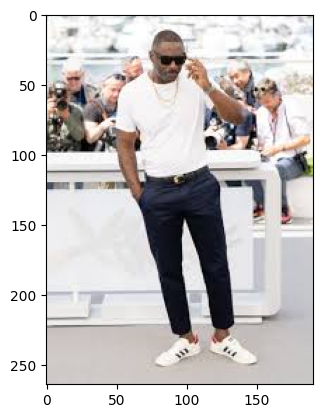

In [7]:
file = "static/images/outfit1.jpeg"

images = plt.imread(file)
plt.imshow(images)

### Display objects detected by YOLO model

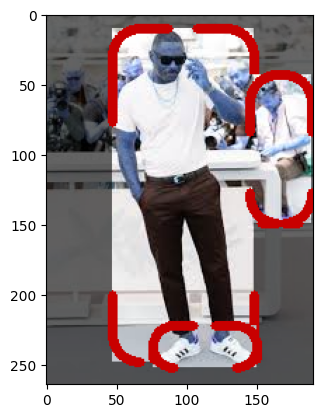

In [10]:
# extract bounding boxes with label
bd, l = epy.extract_boxes_yolovn(MODEL_DETECT_OBJ, images)

# draw rectangle arround detected objects
draw_object_img = epy.display_objects_image(images, bd)
plt.imshow(draw_object_img)

### In our case we will focus on detected person
### YOLO label for person -> 0

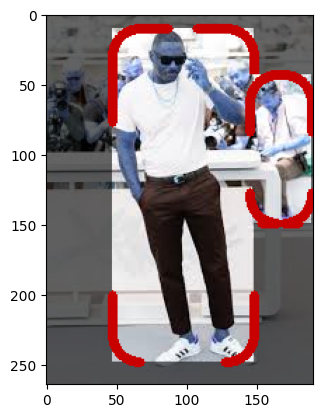

In [11]:
# function to only keep a specific label
bd = epy.detect_label_image(model = MODEL_DETECT_OBJ, image= images, specified_label= 0)

# display person detected
draw_person_img = epy.display_objects_image(images, bd)
plt.imshow(draw_person_img)

# II. Now on these persons we want to detect their clothes

### We will use pretrained Roboflow model

In [12]:
from roboflow import Roboflow
import roboflow

# Connect to Roboflow
roboflow.login()
rf = Roboflow()

# Load pretrained model for clothes recognition
project = rf.workspace().project("clothes-detection-1kl0o")
fashion = project.version(4).model

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


### We get the image of the person

2 person detected


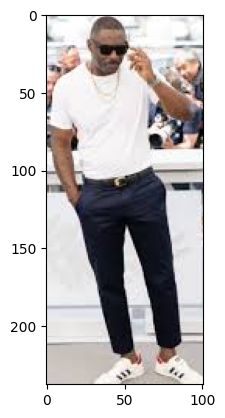

In [13]:
bd = epy.detect_label_image(model = MODEL_DETECT_OBJ, image= images, specified_label= 0)
print(f"{len(bd)} person detected")

img_person_1 = epy.bounding_yolovn(bd[0], images)

plt.imshow(img_person_1)

### we use roboflow on this image

In [14]:
clothes_dict = ecr.detect_clothes_on_person(fashion, img_person_1)
clothes_dict

{'pants': [36.0, 125.0, 90.0, 215.0]}

### Draw the clothes part

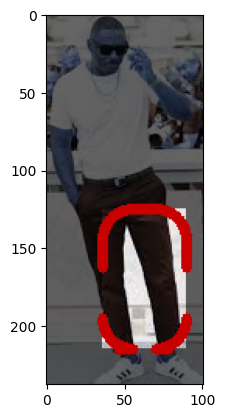

In [16]:
draw_clothes_person = epy.display_objects_image(img_person_1, [clothes_dict["pants"]])

plt.imshow(draw_clothes_person)

# III. Get color of the clothes

### First we create our database of color with which we will try to identify the color of the clothe
The precision of this method will strongly depends on the complexity of our dataset

In [17]:
data_color = pd.DataFrame({
    'color': ['Yellow', 'Red', 'Blue', 'Green', 'Orange', 'Brown', 'Black', 'White', 'Pink', 'Purple', 'Grey', 'Beige', 'Beige'],
    'R': [255, 255, 0, 0, 255, 139, 0, 255, 255, 128, 128, 245, 131],
    'G': [255, 0, 0, 255, 165, 69, 0, 255, 192, 0, 128, 245, 110],
    'B': [0, 0, 255, 0, 0, 19, 0, 255, 203, 128, 128, 220, 89]
})

### we add more color range
additional_data = pd.DataFrame({
    'color': [        'Yellow', 'Yellow', 'Red', 'Red',         'Blue', 'Blue', 'Green', 'Green',         'Orange', 'Orange', 'Brown', 'Brown',         'Black', 'Black', 'White', 'White',         'Pink', 'Pink', 'Purple', 'Purple',         'Grey', 'Grey', 'Beige', 'Beige', 'Turquoise', 'Turquoise', 'Gold', 'Gold',         'Silver', 'Silver'
    ],
    'R': [        255, 204, 255, 204,         173, 0, 173, 0,         255, 204, 165, 96,         76, 51, 255, 255,         255, 204, 191, 96,         192, 96, 255, 196,         178, 0, 255, 204,         211, 153
    ],
    'G': [        255, 204, 102, 0,         214, 0, 214, 85,         195, 106, 85, 35,         76, 51, 255, 255,         224, 153, 153, 0,         192, 96, 255, 196,         242, 128, 255, 204,         211, 153
    ],
    'B': [        153, 0, 153, 0,         255, 128, 153, 0,         0, 0, 42, 0,         76, 51, 255, 255,         203, 102, 255, 128,         192, 96, 245, 176,         255, 0, 0, 0,         211, 153
    ]
})

# Concatenate
data_color = pd.concat([data_color, additional_data], ignore_index=True)
data_color.head()

,color,R,G,B
0,Yellow,255,255,0
1,Red,255,0,0
2,Blue,0,0,255
3,Green,0,255,0
4,Orange,255,165,0


### Save the dataframe -> ./data/data_color.csv

In [26]:
data_color.to_csv("data/data_color.csv", index= False)

### Then we need to identify the dominant color on the image with cluster method

Limitation of this method : 
The pant is clearly black but the image is not centered on it  
So the grey background is identified as the dominant color

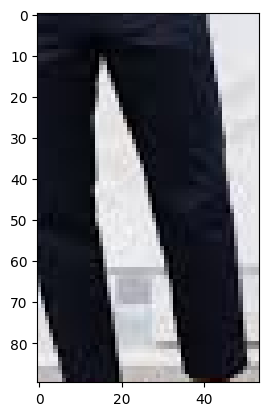

In [18]:
# Example with the pant

img_pant = epy.bounding_yolovn(clothes_dict["pants"], img_person_1)
plt.imshow(img_pant)

[86 86 94]


X does not have valid feature names, but NearestNeighbors was fitted with feature names


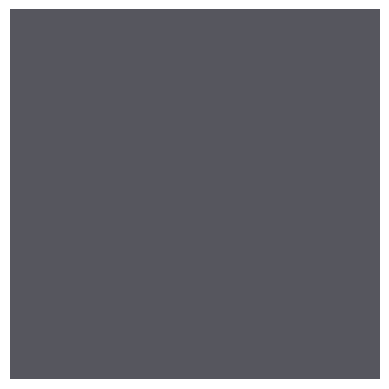

'Grey'

In [19]:
# Get the dominant color

color = emc.get_dominant_color(img_pant)
print(color)
emc.get_name_rgb_color(color, data_color, True)


# IV. Combine all the function

### On one image

In [20]:
mu.detect_person_outfit_image(MODEL_DETECT_OBJ, fashion, images, data_color)


[INFO] : 2 person found
[INFO] : 1 outfit found


X does not have valid feature names, but NearestNeighbors was fitted with feature names


[INFO] : 0 outfit found


,bottom,bottom_color,top,top_color
0,pants,grey,NaN,NaN


In [22]:
path_img_list, img_names = mu.get_extension_folder("static/images/", "jpeg")
path_img_list

['static/images/asap_rocky_outfit.jpeg',
 'static/images/asap_rocky_outfit7.jpeg',
 'static/images/outfit1.jpeg',
 'static/images/asap_rocky_outfit10.jpeg',
 'static/images/asap_rocky_outfit11.jpeg',
 'static/images/asap1.jpeg',
 'static/images/asap_rocky_outfit1.jpeg',
 'static/images/eminem.jpeg']

In [23]:
img_list = [plt.imread(i) for i in path_img_list]


data_clothes_ = mu.detect_outfit_color_batch(img_list, img_names, MODEL_DETECT_OBJ, fashion, data_color)

[INFO] : 1 person found
[INFO] : 0 outfit found
[INFO] : 4 person found
[INFO] : 0 outfit found
[INFO] : 0 outfit found
[INFO] : 0 outfit found
[INFO] : 1 outfit found
[INFO] : 2 person found


X does not have valid feature names, but NearestNeighbors was fitted with feature names


[INFO] : 1 outfit found


X does not have valid feature names, but NearestNeighbors was fitted with feature names


[INFO] : 0 outfit found
[INFO] : 2 person found
[INFO] : 2 outfit found


X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


[INFO] : 1 outfit found
[INFO] : 1 person found


X does not have valid feature names, but NearestNeighbors was fitted with feature names


[INFO] : 0 outfit found
[INFO] : 2 person found
[INFO] : 1 outfit found


X does not have valid feature names, but NearestNeighbors was fitted with feature names


[INFO] : 0 outfit found
[INFO] : 1 person found
[INFO] : 0 outfit found
[INFO] : 3 person found
[INFO] : 0 outfit found
[INFO] : 0 outfit found
[INFO] : 0 outfit found


In [24]:
data_clothes_

,id,bottom,bottom_color,top,top_color
0,asap_rocky_outfit7.jpeg,skirt,silver,NaN,NaN
0,outfit1.jpeg,pants,grey,NaN,NaN
0,asap_rocky_outfit10.jpeg,skirt,black,polar,black
0,asap_rocky_outfit10.jpeg,NaN,NaN,polar,black
0,asap1.jpeg,NaN,NaN,polar,black


# Save the dataframe

In [25]:
data_clothes_.to_csv("data/clothes_data.csv")

In [31]:
data_clothes_.head()

,bottom,bottom_color,top,top_color,id
0,skirt,Silver,NaN,NaN,asap_rocky_outfit7.jpeg
0,pants,Grey,NaN,NaN,outfit1.jpeg
0,NaN,NaN,polar,Black,asap1.jpeg
0,NaN,NaN,NaN,NaN,eminem.jpeg


In [32]:
neighbors_queries = {"bottom": "skirt", "bottom_color": "Silver"}

In [47]:
se.get_search_by_knn(neighbors_queries, 1, data_clothes_, [i for i in range(len(data_clothes_))])

search of similare case to:   bottom bottom_color
0  skirt       Silver



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
X does not have valid feature names, but NearestNeighbors was fitted with feature names


[0]

In [48]:
data1 = ce.detect_person_outfit_image(MODEL_DETECT_OBJ, fashion, images, data_color)
se.similar_outfit_for_image(data1, data_clothes_)

[INFO] : 2 person found
[INFO] : 1 outfit found


X does not have valid feature names, but NearestNeighbors was fitted with feature names


[INFO] : 0 outfit found
search of similare case to:   bottom bottom_color  top  top_color
0  pants         Grey  NaN        NaN



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[1]

In [40]:
data1.values

array([['pants', 'Grey', nan, nan]], dtype=object)

In [29]:
roboflow.login()
rf = Roboflow(api_key=roboflow_token)

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).
